# Классификация текстов

## Сеть прямого распространения  для классификации текстов


![title](img/mlp.png)

* $x$ - входное векторное представление текста
* $h$ – скрытые слои с нелинейными функциями активации
* $y$ – выходы, как правило, один $y$ соответствует одной метке класса 

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$h_2 = g^2(h^1 W^2 + b^2)$

$y = h^2 W^3$

### Нелинейные функции активации

![title](img/activation.png)

### Обучение сети 
### Алгоритм обратного распространения ошибки 

Ошибка: cross entropy: $\text{loss}(y_{true}, \hat{y}_{pred}) = \sum y_{true} \log(\hat{y}_{pred})$ 

1. Прямой проход:
    * вычислить $\hat{y}_{pred}$ с текущими весами на скрытых слоях
    * оценить $\text{loss}(y_{true}, \hat{y}_{pred})$

2. Обратный проход:
    * оценить  $\Delta W_h$ на каждом скрытом слое
    
    $\Delta W_h = \frac {\partial  \text{loss}}{\partial W_{H}} = \frac{\partial \text{loss}}{\partial \hat{y}_{pred}}  \frac{\partial \hat{y}_{pred}}{\partial W_{H}} $
    
    * обновление весов: $ \Delta W_H =-\eta {\frac {\partial \text{loss} } {\partial W_H} }$

### dropout-регуляризация

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$m^1 $~$ Bernouli(r^1)$

$\hat{h^1} = m^1 \odot h^1$

$h_2 = g^2(\hat{h^1} W^2 + b^2)$

$m^2 $~$  Bernouli(r^2)$

$\hat{h^2} = m^2 \odot h^2$

$y =\hat{h^2} W^3$



### Векторное представление текста 


1. Мешок слов [Bag of Words, BoW]
    * $|\text{word} \in V| = N$ – словарь
    * $x \in D$ – документ, $|x| = k$ 
    * $\vec{x}$ – $N$-мерный вектор, $\vec{x}_i = f(\text{word}_i, x_i)$, в котором $k$  ненулевых компонент
        \end{itemize}

2. Распределенное представление слов [Continuous Bag of Words, CBoW])
    * one-hot кодировка: каждое слово $\text{word}$ – $N$-мерный вектор, $\overrightarrow{\text{word}}_i = 1$, иначе – 0
    * плотные вектора – эмбеддинги: каждое слово $\text{word}$ – $d$-мерный вектор, $\overrightarrow{\text{word}}_i \in \mathbb{R}$
	
    Матрица эмбеддингов: $E \in \mathbb{R}^{|V| \times d}$
	
    * $\text{CBOW}(x) = \frac{1}{k} \sum_i^k E_i $
    * $\text{x} = [\overrightarrow{\text{word}}_1  ,\ldots, \overrightarrow{\text{word}}_k ]$


#### Padding
Входные тексты имеют переменную длинну, что неудобно, поэтому предположим, что они все состоят из одинакового количества слов, только часть из этих слов – баластные символы pad.


#### Неизвестные слова (OOV)
Если в тестовом множестве встретилось неизвестное слово, то можно 
* заменить его на pad;
* заменить его на unk.  Однако в обучающем множестве unk никогда не встречается, поэтому его нужно добавить в обучающее множество искусственным образом. 


#### Word dropout - регуляризация 
Заменяем каждое слово на unk с вероятностью $\frac{\alpha}{|V| + \alpha}$


In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from pymystem3 import Mystem
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


df_neg = pd.read_csv("../data/negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("../data/positive.csv", sep=';', header = None, usecols = [3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df = pd.concat([df_neg, df_pos])
df.columns = ['text', 'sent']
df.text = df.text.apply(words_only)
df.text = df.text.apply(lemmatize)


X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_text_train, X_text_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [3]:
TEXT_LENGTH = 10
VOCABULARY_SIZE = 20000
EMBEDDING_DIM = 100
DIMS = 250
MAX_FEATURES = 5000

batch_size = 32
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 5

## Сеть прямого распространения

### BoW 

In [4]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_text_train)
tokenizer

In [5]:
sequences = tokenizer.texts_to_sequences(X_text_train)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(X_text_test)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [6]:
print('First seq:',sequences[0])
print('First doc:',X_train[0])

First seq: [6, 3, 7, 2, 59, 440, 71, 2718]
First doc: [0. 0. 1. ... 0. 0. 0.]


In [7]:
le = LabelEncoder()
le.fit(['pos', 'neg'])
y_train_cat = np_utils.to_categorical(le.transform(y_train), 2)
y_test_cat = np_utils.to_categorical(le.transform(y_test), 2)

print(y_train_cat[0])

[0. 1.]


In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 136780 samples, validate on 15198 samples
Epoch 1/5
136780/136780 [==============================] - 73s 533us/step - loss: 0.5085 - acc: 0.7449 - val_loss: 0.4776 - val_acc: 0.7680
Epoch 2/5
136780/136780 [==============================] - 71s 519us/step - loss: 0.4394 - acc: 0.7935 - val_loss: 0.4743 - val_acc: 0.7689
Epoch 3/5
136780/136780 [==============================] - 75s 550us/step - loss: 0.3710 - acc: 0.8357 - val_loss: 0.4949 - val_acc: 0.7707
Epoch 4/5
136780/136780 [==============================] - 79s 578us/step - loss: 0.2897 - acc: 0.8789 - val_loss: 0.5502 - val_acc: 0.7658
Epoch 5/5
136780/136780 [==============================] - 72s 525us/step - loss: 0.2113 - acc: 0.9167 - val_loss: 0.6317 - val_acc: 0.7695


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 640,386
Trainable params: 640,386
Non-trainable params: 0
_________________________________________________________________


In [10]:
pred = model.predict_classes(X_test)
pred = le.inverse_transform(pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision:   0.76
Recall:   0.76
F1-measure:   0.76
Accuracy:   0.76
             precision    recall  f1-score   support

        neg       0.75      0.78      0.76     36949
        pos       0.77      0.75      0.76     37907

avg / total       0.76      0.76      0.76     74856



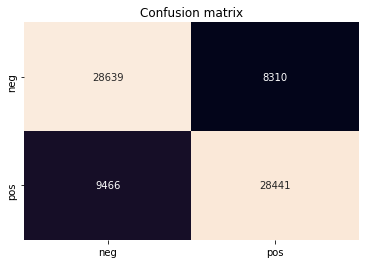

In [11]:
from sklearn.metrics import *



print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))



sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()

In [ ]:
### CBoW – случайно инициализированные эмбеддинги

In [12]:
sequences = tokenizer.texts_to_sequences(X_text_train)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(X_text_test)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [13]:
X_train[0]

array([   6,  144,    2,  296,   18,   12,  120,  344, 3730, 1339],
      dtype=int32)

In [14]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=TEXT_LENGTH))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 136780 samples, validate on 15198 samples
Epoch 1/5
136780/136780 [==============================] - 129s 942us/step - loss: 0.5273 - acc: 0.7285 - val_loss: 0.5044 - val_acc: 0.7457
Epoch 2/5
136780/136780 [==============================] - 133s 973us/step - loss: 0.4744 - acc: 0.7687 - val_loss: 0.5054 - val_acc: 0.7448
Epoch 3/5
136780/136780 [==============================] - 133s 970us/step - loss: 0.4354 - acc: 0.7941 - val_loss: 0.5308 - val_acc: 0.7317
Epoch 4/5
136780/136780 [==============================] - 133s 976us/step - loss: 0.4095 - acc: 0.8108 - val_loss: 0.5652 - val_acc: 0.7283
Epoch 5/5
136780/136780 [==============================] - 130s 950us/step - loss: 0.3926 - acc: 0.8205 - val_loss: 0.5910 - val_acc: 0.7283


In [15]:
pred = model.predict_classes(X_test)
pred = le.inverse_transform(pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision:   0.73
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.73
             precision    recall  f1-score   support

        neg       0.73      0.71      0.72     36949
        pos       0.73      0.74      0.73     37907

avg / total       0.73      0.73      0.73     74856



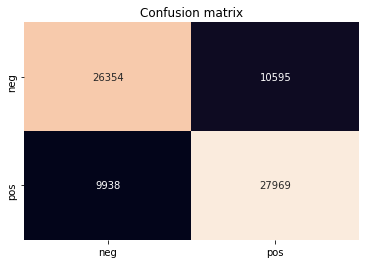

In [16]:
from sklearn.metrics import *



print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))



sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()

In [17]:
%%time

import numpy as np
emb_path = '/NLP/embeddings/wiki.ru.vec'

words = []

embeddings_index = {}
f = open(emb_path)
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 2min 56s, sys: 10.4 s, total: 3min 7s
Wall time: 3min 19s


In [18]:
print(len(embeddings_index))

1775997


In [19]:
word_index = tokenizer.word_index
len(word_index)

158393

In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=TEXT_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)


Train on 136780 samples, validate on 15198 samples
Epoch 1/5
136780/136780 [==============================] - 36s 263us/step - loss: 0.6095 - acc: 0.6625 - val_loss: 0.5873 - val_acc: 0.6855
Epoch 2/5
136780/136780 [==============================] - 34s 252us/step - loss: 0.5886 - acc: 0.6806 - val_loss: 0.5967 - val_acc: 0.6783
Epoch 3/5
136780/136780 [==============================] - 35s 253us/step - loss: 0.5833 - acc: 0.6861 - val_loss: 0.5887 - val_acc: 0.6788
Epoch 4/5
136780/136780 [==============================] - 33s 245us/step - loss: 0.5800 - acc: 0.6877 - val_loss: 0.5854 - val_acc: 0.6869
Epoch 5/5
136780/136780 [==============================] - 33s 243us/step - loss: 0.5785 - acc: 0.6894 - val_loss: 0.6002 - val_acc: 0.6741


Precision:   0.73
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.73
             precision    recall  f1-score   support

        neg       0.73      0.71      0.72     36949
        pos       0.73      0.74      0.73     37907

avg / total       0.73      0.73      0.73     74856



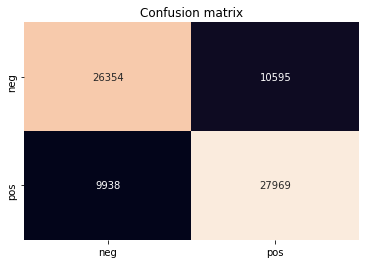

In [22]:
from sklearn.metrics import *



print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))



sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()